# Implementação de uma classe para simular um array de microfones 

A ideia desse jupyter é implementar uma classe que receba o caminho para um arquivo de áudio WAV e realize todo o processamento para simular um array de microfones com ou sem ruído.

O construtor da classe deverá realizar todo o processamento, setando os arrays de sinais e de delays, que serão públicos. Deverá haver um método que retorna essas dois arrays.

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from IPython.display import Audio

## Abrindo um áudio para para testar as funções

A simulação 3 contém apenas um arquivo mono de um sinal de volz puro. Vou criar funções para simular um array de microfones.

In [2]:
caminhoSinal = '/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono.wav'

sinalPuroMono, freqAmostragem = librosa.load(caminhoSinal, sr=None, mono=True)

In [3]:
Audio(data=sinalPuroMono, rate=freqAmostragem)

## Definição de funções

#### Função para gerar ruído branco

In [4]:
def gerarRuidoBranco(qtdAmostras, amplitude):
    
    media        = 0
    desvioPadrao = 1
    
    return amplitude * np.random.normal(media, desvioPadrao, size=qtdAmostras)

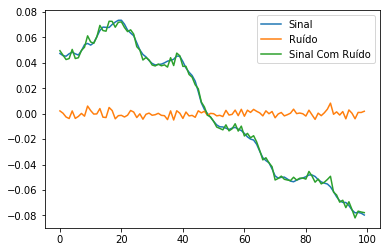

In [5]:
ruido = gerarRuidoBranco(len(sinalPuroMono), 0.0025)
sinalComRuido = sinalPuroMono + ruido

inicio = 10000
fim    = 10100

plt.plot(sinalPuroMono[inicio:fim], label="Sinal")
plt.plot(ruido[inicio:fim], label="Ruído")
plt.plot(sinalComRuido[inicio:fim], label="Sinal Com Ruído")
plt.legend()
plt.show()

In [6]:
Audio(data=sinalComRuido, rate=freqAmostragem)

#### Função para gerar um array de microfones e o delay entre eles

A função abaixo vai receber um sinal mono e vai gerar um array de sinais. Basta copiar e colar o sinal mono e defasar aleatoriamente. Essa função vai devolver o array de sinais e o delay entre eles.

In [7]:
def simularArrayMicrofones(sinalPuroMono, qtdMics):
    
    # ARRAY DE SINAIS
    arraySinaisSimulados = []
    arrayDelays          = [0]
    
    # VOU CRIAR qtdMics SINAIS QUE SAO O PROPRIO SINAL PURO, MAS DEFASADOS ALEATORIAMENTE
    for i in range(qtdMics):
        
        # O PRIMEIRO MICROFONE NAO VAI TER DEFASAGEM EM RELACAO AO SINAL PURO
        if i == 0:
            arraySinaisSimulados.append(sinalPuroMono)
            continue
        
        # GERANDO UM DELAY (em amostras, nao em segundos) ALEATORIO PARA O MIC DA VEZ
        delayAleatorio = randint(-30,30)
        arrayDelays.append(delayAleatorio)
        
        # SE FOR POSITIVO, EU COMO UMA PARTE DO SINAL NO COMECO E PREENCHO COM ZEROS NO FINAL
        if delayAleatorio >= 0:
            sinalMicAtual = np.concatenate((sinalPuroMono[delayAleatorio:], np.zeros(delayAleatorio)))
            
        # SE FOR NEGATIVO, EU COLOCO ZEROS NO COMECO E CORTO DO FINAL
        else:
            sinalMicAtual = np.concatenate((np.zeros(-delayAleatorio), sinalPuroMono[:delayAleatorio]))
            
        # COLOCO O SINAL COPIADO E DEFASADO NO ARRAY DE MICROFONES
        arraySinaisSimulados.append(sinalMicAtual)
    
    return arraySinaisSimulados, arrayDelays

[0, 4, 23, -16, 21, -5, -14, -28]


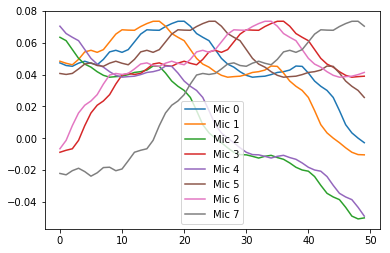

In [8]:
qtdMics = 8
arraySinaisSimulados, arrayDelays = simularArrayMicrofones(sinalPuroMono, qtdMics)

print(arrayDelays)

inicio = 10000
fim    = 10050

for i in range(qtdMics):
    plt.plot(arraySinaisSimulados[i][inicio:fim], label="Mic "+str(i))
    
plt.legend()
plt.show()

#### Função para adicionar ruido a cada um dos microfones

O ruído não poderá ser defasado, pois ele vem de todas as direções. Essa função vai utilizar a função que gera o ruído.

In [9]:
def adicionarRuido(arraySinaisSimulados, amplitudeRuido):
    
    ruido = gerarRuidoBranco(len(arraySinaisSimulados[0]), amplitudeRuido)
    
    for i, sinalAtual in enumerate(arraySinaisSimulados):
        arraySinaisSimulados[i] = sinalAtual + ruido
    
    return arraySinaisSimulados

In [10]:
qtdMics = 8
arraySinaisSimulados, arrayDelays = simularArrayMicrofones(sinalPuroMono, qtdMics)
arraySinaisSimulados = adicionarRuido(arraySinaisSimulados, 0.05)
sinalSemBeamforming  = np.sum(arraySinaisSimulados, axis=0)/len(arraySinaisSimulados)

In [11]:
print("Sinal de um único microfone com ruído")
Audio(data=arraySinaisSimulados[0], rate=freqAmostragem)

Sinal de um único microfone com ruído


In [12]:
print("Sinal dos microfones somados (sem beamforming)")
Audio(data=sinalSemBeamforming, rate=freqAmostragem)

Sinal dos microfones somados (sem beamforming)


#### Função construtora para unir tudo

Abaixo, vou criar a função construtora que apenas recebe o caminho para um arquivo WAV, a quantidade de microfones desejada e se deve adicionar ruido branco nos microfones. 

Aqui, como retorno, ela vai enviar o array de sinais simulados e delay entre eles. Mas, quando for implementar a classe, de fato, não posso fazer o construtor retornar alguma coisa. Por isso, esses dois arrays citados serão globais na classe, e haverá uma função que retorna os dois.

In [13]:
def construtor(caminhoArquivo, qtdMics, amplitudeRuido=None):
    
    # ABRINDO O ARQUIVO MONO PURO
    sinalPuroMono, freqAmostragem = librosa.load(caminhoArquivo, sr=None, mono=True)
    
    # COLOCANDO A DEFASAGEM ENTRE OS MICROFONES
    arraySinaisSimulados, arrayDelays = simularArrayMicrofones(sinalPuroMono, qtdMics)
    
    # ADICIONANDO RUIDO
    if amplitudeRuido != None:
        arraySinaisSimulados = adicionarRuido(arraySinaisSimulados, amplitudeRuido)
    
    return arraySinaisSimulados, arrayDelays

In [18]:
caminhoArquivo = '/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono2Segundos.wav'
arraySinaisSimulados, arrayDelays = construtor(caminhoArquivo, qtdMics=4, amplitudeRuido=0.01)

In [19]:
Audio(data=arraySinaisSimulados[0], rate=freqAmostragem)

# Finalmente criando a classe